In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
ticker = "GILD"
data_source = "yahoo"
start_date = "2006-01-01"
end_date = "2022-01-24"
predict_date = "2022-01-24"
valid_date = "2022-01-25"

In [13]:
df = web.DataReader(ticker, data_source=data_source, start=start_date, end=end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,13.8325,13.1200,13.2500,13.6750,17228400.0,11.039873
2006-01-04,13.9925,13.6525,13.7075,13.8625,17344400.0,11.191246
2006-01-05,14.3150,14.0000,14.1100,14.1550,17982800.0,11.427379
2006-01-06,14.4125,14.1600,14.2750,14.2575,14891600.0,11.510127
2006-01-09,14.7325,14.3900,14.7325,14.4775,16164000.0,11.687737


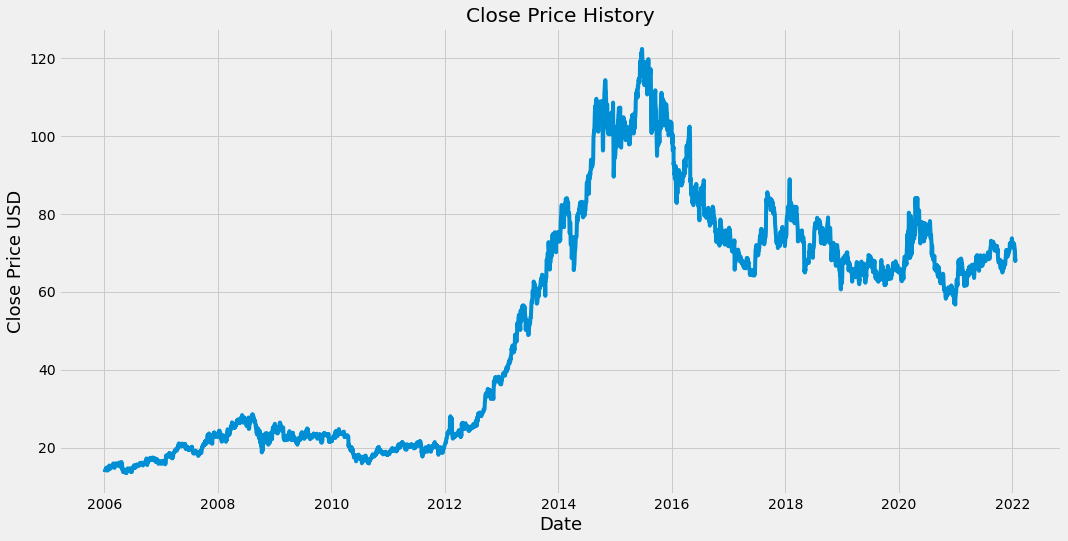

In [11]:
#Chart
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.savefig("PriceHistory.png", format="png")

In [5]:
#Training Data
data = df.filter(["Close"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
#training_data_len

#Scaled Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
#scaled_data

train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
#Convert to arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape Data (3 Dim)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

[array([0.00218346, 0.00390724, 0.00659633, 0.00753867, 0.00956124,
       0.00767657, 0.00730883, 0.01077938, 0.01298582, 0.01220437,
       0.01119308, 0.01243421, 0.00875681, 0.00606771, 0.00979107,
       0.00829714, 0.01185962, 0.01376727, 0.00953826, 0.01636443,
       0.01783539, 0.01599669, 0.01597371, 0.01441081, 0.01514629,
       0.01293985, 0.01052656, 0.0122963 , 0.01248018, 0.01503138,
       0.01709991, 0.01781241, 0.01772047, 0.01431888, 0.0186628 ,
       0.01730676, 0.01818015, 0.02279988, 0.01958216, 0.01677814,
       0.01732975, 0.0145717 , 0.01321566, 0.01227332, 0.01615757,
       0.01567492, 0.01687007, 0.01778943, 0.02096118, 0.02296077,
       0.02100715, 0.02197247, 0.02130594, 0.01965111, 0.02057046,
       0.01900756, 0.01974304, 0.01997288, 0.01813418, 0.01900756])]
[0.018203126331580027]

[array([0.00218346, 0.00390724, 0.00659633, 0.00753867, 0.00956124,
       0.00767657, 0.00730883, 0.01077938, 0.01298582, 0.01220437,
       0.01119308, 0.01243421, 0.0

2022-01-25 20:32:44.850057: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
#Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

#Train model
model.fit(x_train, y_train, batch_size=1, epochs=5)

####################################################################

#Create test dataset
#New array from containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#Create data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

    
#Convert data into numpy array
x_test = np.array(x_test)

#Reshape Data (3 Dim)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

#Get model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Get RMSE (root mean squared error)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )

Epoch 1/5
 112/3175 [>.............................] - ETA: 2:08 - loss: 1.8409e-04

KeyboardInterrupt: 

/Users/femu/opt/anaconda3/envs/dhbw/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


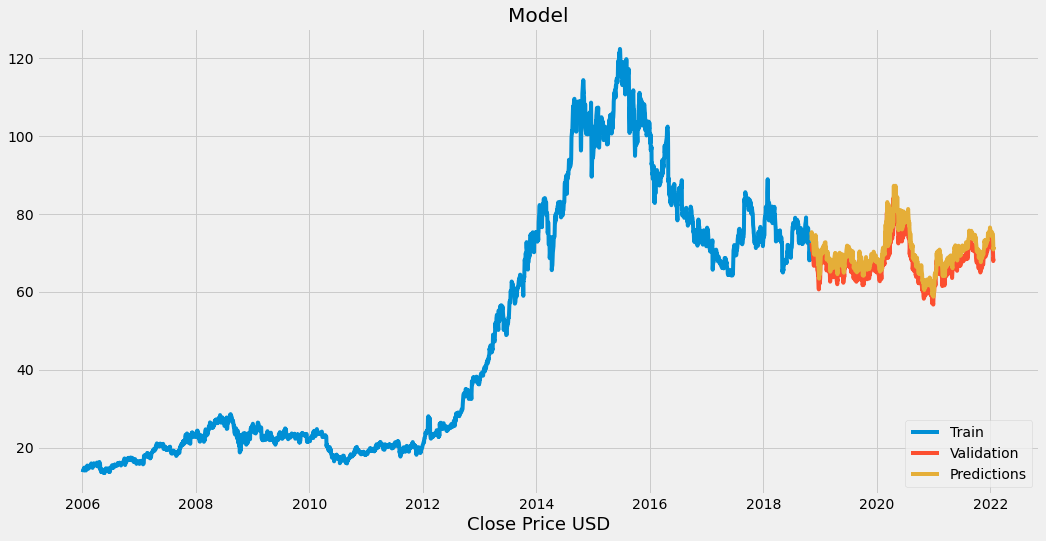

<Figure size 432x288 with 0 Axes>

In [14]:
#Plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions

#Visualize data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.xlabel("Close Price USD", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()
plt.savefig("ModelPrediction.png", format="png")

In [15]:
#Show valid and predicted prices
valid.head()

,Close,Predictions
Date,,
2018-11-07,72.480003,73.163605
2018-11-08,71.879997,75.221367
2018-11-09,71.180000,74.589752
2018-11-12,70.489998,73.943123
2018-11-13,70.919998,73.285095


In [9]:
###Predicted den Preis am Tag nach dem "predict_date" Datum### 

#Get quote
acn_quote = web.DataReader(ticker, data_source=data_source, start=start_date, end=predict_date)

#New dataframe
new_df = acn_quote.filter(["Close"])

#Get the last 60 days closing prices and convert df to array
last_60_days = new_df[-60:].values

#Scale the data to be vals between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Empty list
X_test = []

#Append
X_test.append(last_60_days_scaled)

#Convert X_test to numpy array
X_test = np.array(X_test)

#Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get predicted scaled price
pred_price = model.predict(X_test)

#Undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[71.44347]]


In [18]:
###Korrekter Preis an dem Tag###
ticker_quote2 = web.DataReader(ticker, data_source=data_source, start=valid_date, end=valid_date)
print(ticker_quote2["Close"][0])

Date
2022-01-25    68.839996
2022-01-25    68.839996
Name: Close, dtype: float64
